In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.signal import find_peaks
import yaml


In [2]:
# Map parameters
map_name = 'RCA1'
dir_name = 'utilities/maps'
map_dir = os.path.join(dir_name, map_name)
waypoints_file = os.path.join(map_dir, map_name + '_wp.csv')
reverse_waypoints_file = os.path.join(map_dir, map_name + '_wp_reverse.csv')
image_path = os.path.join(map_dir, map_name + '.png')
print(image_path)

utilities/maps/RCA1/RCA1.png


In [3]:
# get current working directory
def path_dir(file_path):
    current_working_dir = os.getcwd()

    # remove the last folder from the path to get the base path
    if 'run' in current_working_dir:
        base_path = current_working_dir.split('run')[0]  
    else:
        base_path = current_working_dir  

    # joining the base path with the file path
    dir_path = os.path.join(base_path, file_path)

    # Check if the directory exists
    if not os.path.exists(dir_path):
        print(f"Directory '{dir_path}' does not exist.")
        
    return dir_path

# Function to display a PNG image
def display_png(image_path):
    img = plt.imread(image_path)
    plt.imshow(img, cmap='gray')  # Display the image in grayscale
    plt.axis('off')  # Hide the axis
    plt.show()


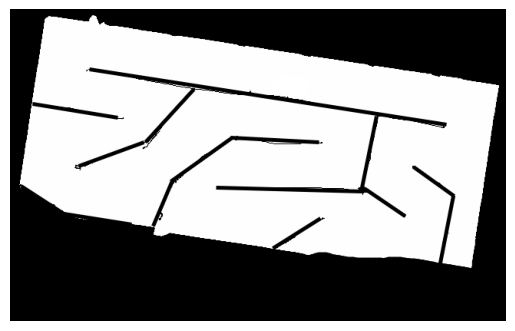

      # s_m       x_m       y_m   psi_rad   kappa_radpm    vx_mps   ax_mps2
0  0.000000 -0.385720  0.134440 -1.760168      0.288317  5.118122 -4.366793
1  0.099997 -0.287237  0.117060 -1.730487      0.305313  5.032081 -4.196012
2  0.199993 -0.188293  0.102699 -1.699097      0.322621  4.947996 -4.039483
3  0.299990 -0.088912  0.091534 -1.665962      0.340110  4.865676 -3.890629
4  0.399987  0.010763  0.083757 -1.631063      0.358038  4.785049 -3.765082


In [4]:
# Display the map image
display_png(image_path= path_dir(image_path))

# read the waypoints file
waypoints_df = pd.read_csv(path_dir(waypoints_file))
# verify the data
print(waypoints_df.head())


In [ ]:
# plot the x and y coordinates of the waypoints
for column in waypoints_df.columns:
    if column != '# s_m':
        plt.figure()
        plt.plot(waypoints_df['# s_m'], waypoints_df['' + column])
        plt.xlabel('s_m')
        plt.ylabel(column)
        plt.title(f'{column} über s_m')
               
# all columns in the same plot with different colors
plt.figure()
for column in waypoints_df.columns:
    if column != '# s_m':
        plt.plot(waypoints_df['# s_m'], waypoints_df[column], label=column)

plt.xlabel('s_m')
plt.ylabel('value')
plt.title('All columns over s_m')
plt.legend()
plt.show()

In [5]:
# Function to plot extrema points
def plot_extrema(waypoints_df, x_col, y_col):
    x = waypoints_df[x_col]
    y = waypoints_df[y_col]

    # Find peaks (maxima)
    peaks, _ = find_peaks(y)
    # Find valleys (minima) by inverting the signal
    valleys, _ = find_peaks(-y)
    
    # Create a list of extrema points sorted by index
    extrema_list = [[peaks, y[peaks].to_numpy()], [valleys, y[valleys].to_numpy()]]
    extrema_list_sorted = sorted([(index, value) for extrema in extrema_list for index, value in zip(extrema[0], extrema[1])], key=lambda x: x[0])
    minima_list = [(index, value) for index, value in extrema_list_sorted if index in valleys]
    maxima_list = [(index, value) for index, value in extrema_list_sorted if index in peaks]
    # plt.figure()
    # plt.plot(x, y, label=y_col)
    # plt.plot(x[peaks], y[peaks], 'ro', label='Maxima')
    # plt.plot(x[valleys], y[valleys], 'go', label='Minima')
    # plt.xlabel(x_col)
    # plt.ylabel(y_col)
    # plt.title(f'{y_col} über {x_col}')
    # plt.legend()
    # plt.show()
    return extrema_list_sorted, minima_list, maxima_list
# Call the function with the appropriate columns
plot_extrema(waypoints_df, '# s_m', ' vx_mps')

([(25, 3.468652),
  (45, 5.535346),
  (64, 3.874625),
  (85, 5.542886),
  (103, 3.629227),
  (291, 12.0465),
  (388, 3.542435),
  (407, 5.419043),
  (420, 4.077911),
  (422, 4.173722),
  (434, 3.464371),
  (463, 5.979441),
  (492, 3.712745),
  (607, 9.903576),
  (703, 3.685099),
  (722, 4.943306),
  (730, 4.60642),
  (740, 5.697159),
  (746, 5.227014),
  (754, 5.808542),
  (766, 4.483052),
  (773, 5.241523),
  (800, 3.55862),
  (860, 7.635711),
  (884, 6.057756),
  (908, 7.512921)],
 [(25, 3.468652),
  (64, 3.874625),
  (103, 3.629227),
  (388, 3.542435),
  (420, 4.077911),
  (434, 3.464371),
  (492, 3.712745),
  (703, 3.685099),
  (730, 4.60642),
  (746, 5.227014),
  (766, 4.483052),
  (800, 3.55862),
  (884, 6.057756)],
 [(45, 5.535346),
  (85, 5.542886),
  (291, 12.0465),
  (407, 5.419043),
  (422, 4.173722),
  (463, 5.979441),
  (607, 9.903576),
  (722, 4.943306),
  (740, 5.697159),
  (754, 5.808542),
  (773, 5.241523),
  (860, 7.635711),
  (908, 7.512921)])

In [13]:
def save_extrema_to_yaml(extrema_list_sorted, min_list, max_list, output_dir, default_global_speed=0.5):
    # Convert extrema list to a dictionary
    # extrema_dict = {'extrema': [{'index': int(index), 'value': float(value)} for index, value in extrema_list_sorted]}
    modified_list = []
    
    
    # go through the list and check if the difference between the values is greater than 0.6
    if extrema_list_sorted[0][1] < extrema_list_sorted[1][1]:
        i = 0
        while True:
            if i == len(extrema_list_sorted):
                modified_list.append(list(extrema_list_sorted[i-1]))
                break
            if abs(extrema_list_sorted[i][1] - extrema_list_sorted[i+1][1]) > 0.6:
                if not min_list:
                    modified_list.append(list(extrema_list_sorted[i]))
                    break
                modified_list.append(list(min_list[0]))
                min_list.pop(0)
                i += 2  # Erhöht i um 2
            else:
                min_list.pop(0)
                i += 2  # Erhöht i um 1, wenn die Bedingung nicht erfüllt ist
            
    # TODO: Implement the case where the first value is a minimum        

    sector_dic = {}
    sector_dic['Sector0'] = {'start': int(0), 'end': int(modified_list[0][0]), 'scaling': default_global_speed}
    
    for i in range(len(modified_list)-1):
        sector_dic['Sector' + str(i+1)] = {'start': int(modified_list[i][0]), 'end': int(modified_list[i+1][0]), 'scaling': default_global_speed}
    
    # split the extrema list into maxima and minima
    num_sector = {'n_sectors': int(len(modified_list))}
    default_speed = {'global_limit': default_global_speed}
    output_file = output_dir+ '/' + 'speed_scaling.yaml'
    
    # Save the dictionary to a YAML file
    with open(output_file, 'w') as file:
        yaml.dump(sector_dic, file, default_flow_style=False, sort_keys=False)
        yaml.dump(default_speed, file, default_flow_style=False)
        yaml.dump(num_sector, file, default_flow_style=False)


# Example usage
extrema_list_sorted, min, max = plot_extrema(waypoints_df, '# s_m', ' vx_mps')
dir_path = path_dir(os.path.join(dir_name, map_name))
save_extrema_to_yaml(extrema_list_sorted, min, max, dir_path)

[[25, 3.468652], [64, 3.874625], [103, 3.629227], [388, 3.542435], [434, 3.464371], [492, 3.712745], [703, 3.685099], [730, 4.60642], [766, 4.483052], [800, 3.55862], [884, 6.057756], [908, 7.512921]]
